# test notebook for stella ZAMS calc code

In [1]:
# imports
import numpy as np
import pandas as pd
from scipy import optimize
from scipy.integrate import solve_ivp
from scipy.interpolate import interpn

# constants
import constants as c
from scipy.constants import N_A

# plotting
import matplotlib.pyplot as plt
import seaborn as sb
sb.set_context("talk")
plt.rcParams['font.family'] = 'monospace'   # Fonts
plt.rcParams['font.monospace'] = 'DejaVu Sans Mono'

In [2]:
import interpolate

Read Sections 18.0, 18.1, and 18.2 of Numerical Recipes, as it will be necessary
to implement the method of shooting to a fitting point (their shootf function) to
solve the boundary-value problem posed by the four coupled ordinary differential
equations of stellar structure and evolution. You will also need a program similar
to the newt function described in Section 9.7 of Numerical Recipes or in the
SciPy documentation to repeatedly call a shootf-like function, calculate updated
boundary values, and ultimately obtain a converged solution. Faster convergence
can usually be obtained by using fractions of the updates suggested by a newt-
like function. Ordinary differential equation (ODE) solvers like those described
in Sections 17.0, 17.1, and 17.2 of Numerical Recipes or the SciPy documentation
are also critical.

In [60]:
import energy
import density


def load_inner(Tc, Pc, factor=1e-12):
    """
    Returns reasonable guess for an integration
    starting point exterior to the absolute center
    """
    rho_c = density.density(Pc,Tc, X=0.7)
    
#     if np.isnan(np.log10(rho_c/(Tc/1e6)**3)):
#         print('Nan logR!')
#         print('Pc',np.log10(Pc))
#         print('Tc',np.log10(Tc))

    m = factor*c.Ms # set start just outside center
    epsilon = energy.energy_gen(rho_c,Tc)
    l = epsilon*m # determine energy generation from pp and CNO
    
    r = (3/(4*np.pi*rho_c))**(1/3) * m**(1/3) # radius start
    
    P = Pc - (3*c.G/(8*np.pi))*((4*np.pi*rho_c/3)**(4/3))*(m**(2/3))
    
    del_rad = energy.del_rad(m, l, P, rho_c, Tc)
    if del_rad > energy.del_ad:
        print('convective core')
        lnT = np.log(Tc) - (np.pi/6)**(1/3)*c.G*(energy.del_ad*rho_c**(4/3))/Pc*m**(2/3)
        T = np.exp(lnT)
    else:
        print('radiative core')
        kappa_c = interpolate.interp_k(rho_c,Tc)
        T = (Tc**4 - (1/(2*c.a*c.c)*(3/(4*np.pi))**(2/3)*kappa_c*epsilon*rho_c**(4/3)*m**(2/3)))**(1/4)
    
    return (l, P, r, T)

def opacity_pressure(rho, T, g):
    return (2/3) * g / interpolate.interp_k(rho,T)

def gas_and_rad_pressure(rho, T, X=0.7):
    mu = 4/(3+5*X)
    return (1/3)*c.a*T**4 + rho*N_A*c.k*T/mu

def rho_solver(rho, T, g):
    diff = 1 - (opacity_pressure(rho, T, g)/gas_and_rad_pressure(rho, T))
    return diff

def load_outer(M_star, L_star, R_star, factor=0.9999):
    """
    Returns reasonable guess for an integration
    starting point interior to the photosphere.
    """
    
    surface_g = c.G*M_star/(R_star**2)
    Teff = (L_star/(4*np.pi*c.sb*R_star**2))**(1/4)
    
    rho = optimize.brentq(rho_solver, 10**-9, 10**-6, args=(Teff, surface_g))
    
    kappa = interpolate.interp_k(rho,Teff)
    P = 2*surface_g/(3*kappa)
    return (L_star*factor, P, R_star*factor, Teff)


def odeEZ(m,v):
    l, P, r, T = v
    rho = density.density(P,T, X=0.7) # density
    del_radiative = energy.del_rad(m, l, P, rho, T)
    del_radiative = (3/(16*np.pi*c.a*c.c))*(P*interpolate.interp_k(rho, T)/T**4)*(l/(c.G*m))
    del_actual = np.minimum(del_radiative, energy.del_ad)
    print(del_radiative)
    dldm = energy.energy_gen(rho,T, psi=1) #change in Luminosity with enclosed mass
    dPdm = -c.G*m/(4*np.pi*r**4) # change in pressure with enclosed mass
    drdm = 1/(4*np.pi*r**2 * rho) # mass conservation eq.
    dTdm = ((-c.G*m*T)/(4*np.pi*P*r**4))*del_actual # change in temperature with enclosed mass
    
    return (dldm, dPdm, drdm, dTdm)
    

In [61]:
def shooter(vec, M_star=1.0*c.Ms,  n=int(1e5), in_factor=1e-10, out_factor=0.9999, M_fit=0.75):
    
    Pc, Tc, L_star, R_star = vec
    
    inn = load_inner(Tc, Pc, factor=in_factor)
    outt = load_outer(M_star, L_star, R_star, factor=out_factor)

    exiting = np.logspace(np.log10(in_factor*c.Ms), np.log10(M_fit*M_star), base = 10.0 , num = n)
    entering = np.flipud(np.logspace(np.log10(M_fit*M_star), np.log10(M_star), base = 10.0 , num = n))

#     exiting_sol = odeint(odeEZ, inn, exiting)
    exiting_sol = solve_ivp(odeEZ, (exiting[0], exiting[-1]), inn, t_eval=exiting).y
#     entering_sol = odeint(odeEZ, outt, entering)
    entering_sol = solve_ivp(odeEZ, (entering[0], entering[-1]), outt, t_eval=entering).y

    dL = exiting_sol[0,-1] - entering_sol[0,-1]
    dP = exiting_sol[1,-1] - entering_sol[1,-1]
    dR = exiting_sol[2,-1] - entering_sol[2,-1]
    dT = exiting_sol[3,-1] - entering_sol[3,-1]

    return np.array([dL, dP, dR, dT])

In [62]:
# surface
M_star = 1.0*c.Ms
L_star = (M_star/c.Ms)**(3.5)*c.Ls # eq. 1.88 HKT
R_star = (M_star/c.Ms)**(0.75)*c.Rs # eq. 1.87 HKT
surface_guess = load_outer(M_star, L_star, R_star, factor=0.9999)
# core
Pc = 2.65e16
# Pc = (3/(8*np.pi))*(c.G*(M_star)**2)/(R_star)**4 # constant density sphere, lower limit!
Tc = 15e6 
# Tc = (1/2)*((4/(3+5*0.7))/(N_A*c.k))*(c.G*M_star)/(R_star) # constant density sphere

core_guess = load_inner(Tc, Pc, factor=1e-12)

vec = (Pc, Tc, L_star, R_star)
args = (1.0*c.Ms, int(1e5), 1e-12, 0.9999, 0.5)
final = optimize.newton(shooter, vec, tol=1e-3, args=args)

radiative core
radiative core
0.004919418743373906
0.004919418743373906
0.004919418743373906
0.004919418743373906
0.004919418743373906
0.004919418743373905
0.004919418743373906
0.004919418743373906
0.004919418743373906
0.004919418743373906
0.004919418743373906
0.004919418743373907
0.004919418743373905
0.004919418743373905
0.004919418743373905
0.004919418743373907
0.004919418743373906
0.004919418743373906
0.004919418743373906
0.004919418743373906
0.004919418743373906
0.004919418743373906
0.004919418743373906
0.004919418743373907
0.004919418743373906
0.004919418743373906
0.004919418743373906
0.004919418743373906
0.004919418743373906
0.004919418743373906
0.004919418743373906
0.004919418743373906
0.004919418743373906
0.004919418743373906
0.004919418743373906
0.004919418743373906
0.004919418743373906
0.004919418743373906
0.004919418743373905
0.004919418743373906
0.004919418743373906
0.004919418743373905
0.004919418743373905
0.004919418743373905
0.004919418743373905
0.004919418743373905
0.00

0.21130982001457987
0.21638961879634805
0.1951247399136056
0.15765864212126202
0.15871532130468283
0.2152886641108205
0.2101892944084858
0.21548712875418508
0.19273916532399327
0.1523187382069555
0.15311120938839154
0.2148258693933248
0.2100969559052097
0.21461269950195055
0.19297876764367095
0.15613899950667873
0.15640480473519264
0.21184859795979355
0.20543895690465616
0.21036288621424204
0.1834195025009491
0.14269807875111246
0.14459678100763373
0.20765247722257474
0.20422199782501366
0.20928420520541235
0.18963984107479404
0.15242488209228428
0.15309725226044232
0.208344718571553
0.20206310774738634
0.2085495017390172
0.18301126794872766
0.13685617855026738
0.13939531460759247
0.21305417776258992
0.2112884436649285
0.21664331519429028
0.2013698894520214
0.16905937244233388
0.17037121380109016
0.2191744164357175
0.2150527407052034
0.22177461547350144
0.1965721709505685
0.15093723559360991
0.1529654127787132
0.22322681505962547
0.21870371739427405
0.22530503379984568
0.20223865331828

0.1250124638034937
0.1250128277319112
0.125013282643606
0.125013282643606
0.12502147123824053
0.12502556575203835
0.12504603971108355
0.12504967980241596
0.12505423003387303
0.1250542300338336
0.12513615261913913
0.1251771355783031
0.1253821896125664
0.12541867138534699
0.12546428532792878
0.12546428528810413
0.12628718434388847
0.1267008190437031
0.12878315286808992
0.12915620281778742
0.12962368495818244
0.12962364404981924
0.13822949323399109
0.1427705725618271
0.16716735685853526
0.1718951983679061
0.17752715872341124
0.1774843236897533
0.22033066924945874
0.24635873842468436
0.46152971082480787
0.541765052265355
0.6436914496736313
0.6119405287667268
0.8839089359271282
1.0398918317216694
2.2681618105348997
2.5645553065366884
3.000775568966263
3.0241771069184886
8.281854797177258
11.637199573109513
45.701136752184134
53.37442932906353
67.25900100841645
68.97474973531213
122.27395989705516
147.8047868838064
234.6717051935279
246.28598765335715
263.0878991109196
261.50892604474063
257

0.030493827786103447
0.030493853434170187
0.030493615257746225
0.030493478317483988
0.03049284203636588
0.030492554250161615
0.030492495021313324
0.03049276397580748
0.03049249664316518
0.030492348978745597
0.030491689685626495
0.030491523919804007
0.030491401638245565
0.03049148398196942
0.030490644507735996
0.030490160891140827
0.030487894918328165
0.030486825757664444
0.030486641227682326
0.030487662801012786
0.030486765186376837
0.030486270121470344
0.03048405677064787
0.030483510029828523
0.030483095843972647
0.030483357085656023
0.03048031147816267
0.03047855207769669
0.030470183997640923
0.030465964685067955
0.030465452383846132
0.03046961328854054
0.030466589780097003
0.030464925759657858
0.03045746798893534
0.03045567075215326
0.03045425788827864
0.03045506758566885
0.030443224102401724
0.030436355054377823
0.030402464244066615
0.030383016947633366
0.030382522284368142
0.030402723896268406
0.030392499113634598
0.030386890460789504
0.03036160643584137
0.03035574493269229
0.0303

0.14475757974793296
-0.14413373876728153
-0.3491927726020897
-0.5840897599333075
-0.4867162850984251
0.17483843854116324
0.16197684148536734
0.04411262719272578
-0.004118918906382474
-0.06888852901626115
-0.04907731992154401
-0.09836469792017684
-0.12964836898003512
-0.34700478435520327
-0.3997361889863108
-0.4863081516878399
-0.4952753891947562
radiative core


/var/folders/0q/4ls9h2fn4lv90qs43vdtzvkw0002tl/T/ipykernel_69915/157277336.py:55: RuntimeWarning: invalid value encountered in scalar power
  Teff = (L_star/(4*np.pi*c.sb*R_star**2))**(1/4)


0.005393864661071733
0.005393864661071733
0.005393864661071732
0.005393864661071733
0.005393864661071733
0.005393864661071732
0.005393864661071732
0.005393864661071732
0.005393864661071732
0.005393864661071733
0.005393864661071733
0.005393864661071733
0.005393864661071732
0.005393864661071732
0.005393864661071733
0.005393864661071733
0.005393864661071732
0.005393864661071732
0.005393864661071733
0.005393864661071733
0.005393864661071733
0.005393864661071733
0.005393864661071733
0.005393864661071733
0.005393864661071733
0.005393864661071733
0.005393864661071733
0.005393864661071732
0.005393864661071733
0.005393864661071732
0.005393864661071733
0.005393864661071733
0.005393864661071732
0.005393864661071732
0.005393864661071732
0.005393864661071732
0.005393864661071733
0.005393864661071733
0.005393864661071733
0.005393864661071733
0.005393864661071733
0.005393864661071732
0.005393864661071733
0.005393864661071733
0.005393864661071733
0.005393864661071733
0.005393864661071732
0.00539386466

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


KeyboardInterrupt: 

In [ ]:
final

In [30]:
vec = (Pc, Tc, L_star, R_star)
args = (1.0*c.Ms, int(1e5), 1e-12, 0.9999, 0.5)

M_star = args[0]
n = args[1]
in_factor = args[2]
out_factor = args[3]
M_fit = args[-1]

Pc, Tc, L_star, R_star = vec

inn = load_inner(Tc, Pc, factor=in_factor)
outt = load_outer(M_star, L_star, R_star, factor=out_factor)

exiting = np.logspace(np.log10(in_factor*c.Ms), np.log10(M_fit*M_star), base = 10.0 , num = n)
entering = np.flipud(np.logspace(np.log10(M_fit*M_star), np.log10(M_star), base = 10.0 , num = n))

#     exiting_sol = odeint(odeEZ, inn, exiting)
exiting_sol = solve_ivp(odeEZ, (exiting[0], exiting[-1]), inn, t_eval=exiting).y
#     entering_sol = odeint(odeEZ, outt, entering)
entering_sol = solve_ivp(odeEZ, (entering[0], entering[-1]), outt, t_eval=entering).y

dL = exiting_sol[0,-1] - entering_sol[0,-1]
dP = exiting_sol[1,-1] - entering_sol[1,-1]
dR = exiting_sol[2,-1] - entering_sol[2,-1]
dT = exiting_sol[3,-1] - entering_sol[3,-1]



radiative core
0.004919418743373906
0.004919418743373906
0.004919418743373905
0.004919418743373906
0.004919418743373906
0.004919418743373905
0.004919418743373905
0.004919418743373905
0.004919418743373906
0.004919418743373906
0.004919418743373906
0.004919418743373905
0.004919418743373905
0.004919418743373905
0.004919418743373905
0.004919418743373906
0.004919418743373905
0.004919418743373905
0.004919418743373906
0.004919418743373906
0.004919418743373906
0.004919418743373907
0.004919418743373907
0.004919418743373907
0.004919418743373906
0.004919418743373906
0.004919418743373906
0.004919418743373905
0.004919418743373906
0.004919418743373907
0.004919418743373905
0.004919418743373905
0.004919418743373905
0.004919418743373907
0.004919418743373905
0.004919418743373906
0.004919418743373906
0.004919418743373906
0.004919418743373905
0.004919418743373906
0.004919418743373905
0.004919418743373905
0.004919418743373905
0.004919418743373905
0.004919418743373906
0.004919418743373904
0.00491941874337390

0.2154871287541851
0.19273916532399343
0.15231873820695602
0.15311120938839204
0.21482586939332476
0.21009695590520944
0.2146126995019503
0.19297876764367083
0.15613899950667848
0.15640480473519167
0.2118485979597936
0.2054389569046562
0.21036288621424204
0.18341950250094904
0.14269807875111246
0.1445967810076338
0.20765247722257474
0.20422199782501363
0.20928420520541233
0.18963984107479392
0.15242488209228425
0.15309725226044232
0.20834471857155326
0.20206310774738634
0.20854950173901737
0.18301126794872727
0.13685617855026558
0.13939531460759064
0.21305417776258995
0.2112884436649285
0.21664331519429028
0.20136988945202136
0.1690593724423339
0.17037121380108947
0.21917441643571758
0.2150527407052034
0.2217746154735019
0.1965721709505669
0.15093723559360556
0.15296541277870948
0.22322681505962547
0.21870371739427408
0.22530503379984568
0.20223865331828772
0.1581898659438466
0.15977024934499123
0.22705391785772194
0.22218191095189607
0.22772180531347475
0.20792365056277323
0.170018065

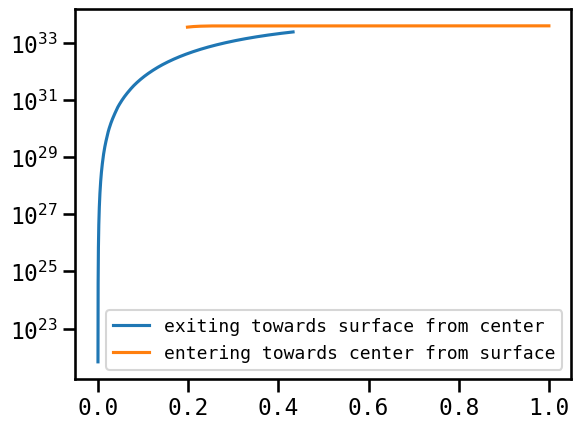

In [37]:
R_sun = c.Rs

y_o = exiting_sol
y_i = entering_sol

# l, P, r, T

plt.plot(y_o[2]/R_star, y_o[0], label='exiting towards surface from center')
plt.plot(y_i[2]/R_star, y_i[0], label='entering towards center from surface')

# plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=13)
plt.show()

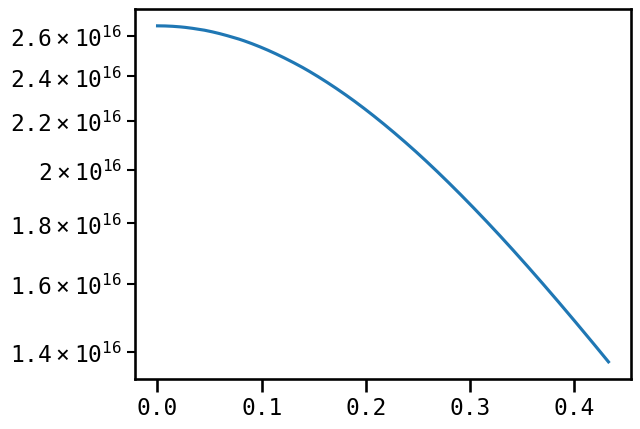

In [38]:
plt.plot(y_o[2]/R_star, y_o[1])
plt.yscale('log')

(0.0, 1.0)

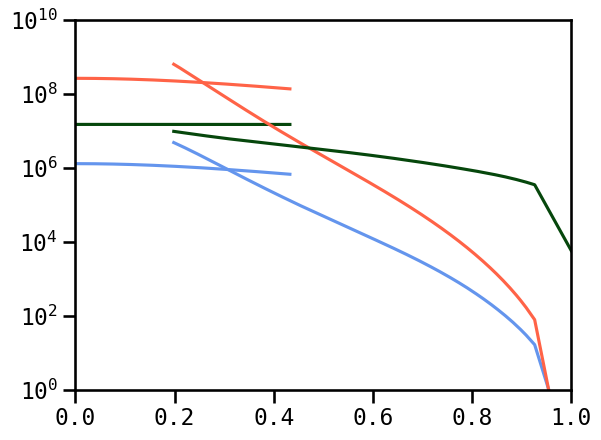

In [39]:
# reproduce figure 9.1 in HKT
plt.plot(y_o[2]/R_star, density.density(y_o[1],y_o[3], X=0.7)*1e5, color='cornflowerblue')
plt.plot(y_o[2]/R_star, y_o[1]*1e-8, color='tomato')
plt.plot(y_o[2]/R_star, y_o[3], color='xkcd:forest green')

plt.plot(y_i[2]/R_star, density.density(y_i[1],y_i[3], X=0.7)*1e5, color='cornflowerblue')
plt.plot(y_i[2]/R_star, y_i[1]*1e-8, color='tomato')
plt.plot(y_i[2]/R_star, y_i[3], color='xkcd:forest green')

plt.yscale('log')
plt.ylim(1,1e10)
plt.xlim(0,1)

In [45]:
rho = density.density(y_o[1],y_o[3], X=0.7) # density
# rho_p = pcalc.density(y_o[:,1],y_o[:,3], 4/(3+5*0.7))
del_radiative = energy.del_rad(exiting, y_o[0], y_o[1], rho, y_o[3])
del_rad2 = (3/(16*np.pi*c.a*c.c))*(y_o[1]*interpolate.interp_k(rho, y_o[3])/y_o[3]**4)*(y_o[0]/(c.G*exiting))
kappa = interpolate.interp_k(rho, y_o[3])
# del_rad3 = (3/(16*np.pi*c.a*c.c))*(y_o[:,1]*ptab.opacityValue(log_R, log_T, opacityTable, rho, y_o[:,3])/y_o[:,3]**4)*(y_o[:,0]/(c.G*exiting))
# patrick_kappa = ptab.opacityValue(log_R, log_T, opacityTable, rho, y_o[:,3])
del_actual = np.minimum(del_radiative, energy.del_ad)

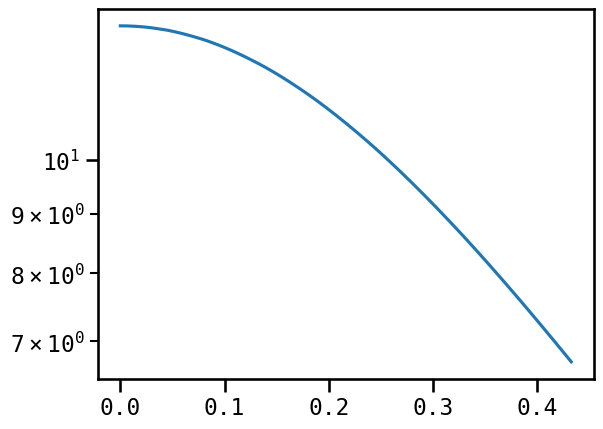

In [49]:
plt.plot(y_o[2]/R_star,rho)
# plt.plot(exiting/M_star,rho_p)
plt.yscale('log')

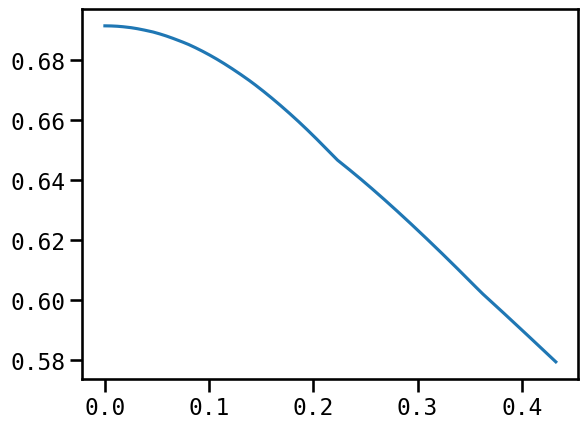

In [50]:
plt.plot(y_o[2]/R_star,kappa)
# plt.plot(exiting/M_star,patrick_kappa)

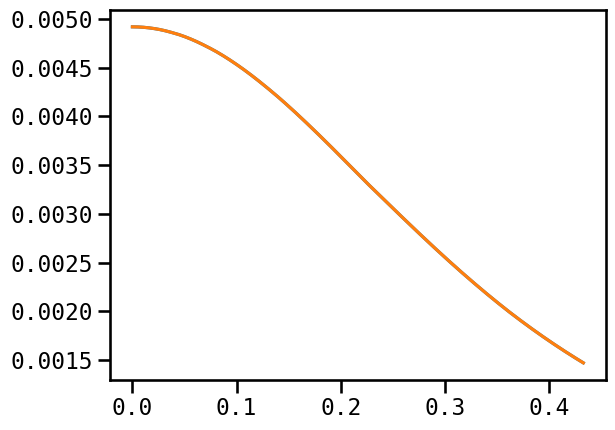

In [51]:
plt.plot(y_o[2]/R_star,del_radiative)
plt.plot(y_o[2]/R_star,del_rad2)
# plt.plot(exiting/M_star,del_rad3)
# plt.hlines(0.4, 0,0.5)
# plt.yscale('log')

In [55]:
energy.del_rad?


In [57]:
entering

array([1.98900000e+33, 1.98898621e+33, 1.98897243e+33, ...,
       9.94513787e+32, 9.94506893e+32, 9.94500000e+32])

In [ ]:
rho = density.density(y_i[1],y_i[3], X=0.7) # density
# rho_p = pcalc.density(y_o[:,1],y_o[:,3], 4/(3+5*0.7))
del_radiative = energy.del_rad(entering, y_i[0], y_i[1], rho, y_i[3])
del_rad2 = (3/(16*np.pi*c.a*c.c))*(y_o[1]*interpolate.interp_k(rho, y_i[3])/y_i[3]**4)*(y_i[0]/(c.G*entering))
kappa = interpolate.interp_k(rho, y_i[3])
# del_rad3 = (3/(16*np.pi*c.a*c.c))*(y_o[:,1]*ptab.opacityValue(log_R, log_T, opacityTable, rho, y_o[:,3])/y_o[:,3]**4)*(y_o[:,0]/(c.G*exiting))
# patrick_kappa = ptab.opacityValue(log_R, log_T, opacityTable, rho, y_o[:,3])
del_actual = np.minimum(del_radiative, energy.del_ad)

plt.plot(y_i[2]/R_star,del_radiative, color='cornflowerblue')
plt.plot(y_i[2]/R_star,del_rad2, color='tomato')
# plt.plot(exiting/M_star,del_rad3)
plt.hlines(0.4, 0,1, color='k', ls='--')
plt.yscale('log')